In [13]:
import numpy as np
from matplotlib import pyplot as plt

from collections import defaultdict
import uproot
import re
from glob import glob

In [14]:
files = glob("./*.root")
files

['./Out_DB.root',
 './Out_Signal.root',
 './Out_ST.root',
 './Out_W.root',
 './Out_DY.root',
 './Out_Data.root',
 './Out_TTbkg.root']

In [15]:
files = {}
for file in glob("./*.root"):
    name = re.findall(r".*_([A-z]*)\.root", file)[0]
    files[name] = uproot.open(file)


In [16]:
files

{'DB': <ReadOnlyDirectory '/' at 0x7f4f22314910>,
 'Signal': <ReadOnlyDirectory '/' at 0x7f4f30bf0be0>,
 'ST': <ReadOnlyDirectory '/' at 0x7f4f22f51d80>,
 'W': <ReadOnlyDirectory '/' at 0x7f4f22f53760>,
 'DY': <ReadOnlyDirectory '/' at 0x7f4f22f53d90>,
 'Data': <ReadOnlyDirectory '/' at 0x7f4f22f521a0>,
 'TTbkg': <ReadOnlyDirectory '/' at 0x7f4f22f3c7c0>}

In [17]:
data_hists = list(files['Data'].classnames().keys())
data_hists

['h_Muon_eta;1',
 'h_Muon_pt;1',
 'h_Electron_eta;1',
 'h_Electron_pt;1',
 'Muon_Electron_invariant_mass;1',
 'leading_lepton_pt;1']

In [18]:
mc_hists = [re.findall(r"(.*);1", i)[0]+"_weighted;1" for i in data_hists]
mc_hists

['h_Muon_eta_weighted;1',
 'h_Muon_pt_weighted;1',
 'h_Electron_eta_weighted;1',
 'h_Electron_pt_weighted;1',
 'Muon_Electron_invariant_mass_weighted;1',
 'leading_lepton_pt_weighted;1']

In [19]:
df = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))
for sample in files:
    for hist in data_hists:
        if sample == 'Data':
            df[hist]['Data'][sample] = files[sample][hist].to_numpy()
        else:
            df[hist]['MC'][sample] = files[sample][hist.replace(";1", "_weighted;1")].to_numpy()


In [20]:
def stacked_histo(n_data, n_mc: dict, title=None, xlabel=r"$p_{\mathrm{T}}$ [GeV]", savepath=None) -> None:
    fig, axs = plt.subplots(2,1, gridspec_kw={'height_ratios':[3,1]})
    if title:
        fig.suptitle(f"{title}")
    bottom = np.zeros(shape=n_data[0].shape)
    # sort n_mc by max
    n_mc_sorted = {key: value for key, value in sorted(n_mc.items(), key=lambda x: x[1][0].max())}
    for sample in n_mc_sorted:
        centers = (n_mc[sample][1][1:]+n_mc[sample][1][:-1])/2.
        width = centers[1]-centers[0]
        axs[0].bar(centers,n_mc[sample][0], width=width,bottom=bottom, align='center', label=sample)
        bottom+=n_mc[sample][0]
    centers_data = (n_data[1][1:]+n_data[1][:-1])/2.
    axs[0].errorbar(centers_data, n_data[0], yerr=np.sqrt(n_data[0]), fmt='.',label='data')
    axs[0].legend()
    axs[0].set_ylabel("N")
    xmin, xmax = axs[0].get_xbound()
    summed_mc = np.zeros(shape=n_mc[sample][0].shape) 
    for sample in n_mc:
        summed_mc+= n_mc[sample][0]
    ratio = n_data[0]/summed_mc
    data_err, mc_err = np.sqrt(n_data[0]), np.sqrt(summed_mc)
    ratio_err = np.sqrt((data_err/summed_mc)**2+(n_data[0]*mc_err/(summed_mc**2))**2)
    axs[1].errorbar(centers_data, ratio, yerr=ratio_err, fmt='.', label = 'ratio')
    axs[1].set_xbound(xmin,xmax)
    axs[1].axhline(1, color='k', linestyle='--')
    axs[1].set_xlabel(f"{xlabel}")
    axs[1].set_ylabel(f"Ratio")
    delta = np.abs(ratio-1)
    axs[1].set_ylim([1-(np.nanmax(delta)+0.1),1+(np.nanmax(delta)+0.1)])
    #axs[1].set_ybound([0.5,1.5])
    if savepath:
        plt.tight_layout()
        plt.savefig(f"{savepath}")
    plt.show()

/tmp/ipykernel_21803/3404996798.py:21: RuntimeWarning: invalid value encountered in divide
  ratio = n_data[0]/summed_mc
/tmp/ipykernel_21803/3404996798.py:23: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/summed_mc)**2+(n_data[0]*mc_err/(summed_mc**2))**2)


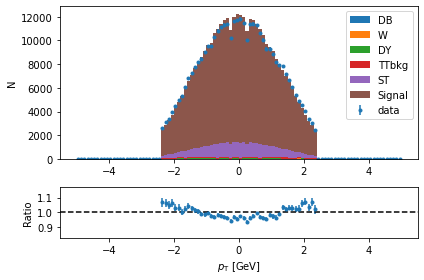

/tmp/ipykernel_21803/3404996798.py:21: RuntimeWarning: invalid value encountered in divide
  ratio = n_data[0]/summed_mc
/tmp/ipykernel_21803/3404996798.py:23: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/summed_mc)**2+(n_data[0]*mc_err/(summed_mc**2))**2)


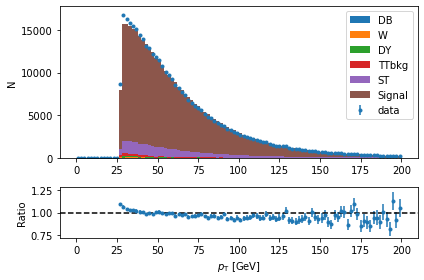

/tmp/ipykernel_21803/3404996798.py:21: RuntimeWarning: invalid value encountered in divide
  ratio = n_data[0]/summed_mc
/tmp/ipykernel_21803/3404996798.py:23: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/summed_mc)**2+(n_data[0]*mc_err/(summed_mc**2))**2)


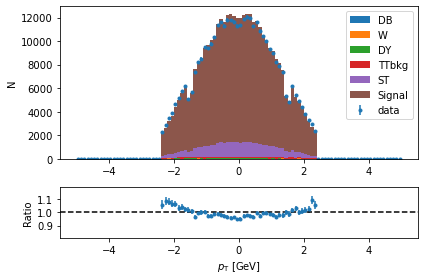

/tmp/ipykernel_21803/3404996798.py:21: RuntimeWarning: invalid value encountered in divide
  ratio = n_data[0]/summed_mc
/tmp/ipykernel_21803/3404996798.py:23: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/summed_mc)**2+(n_data[0]*mc_err/(summed_mc**2))**2)


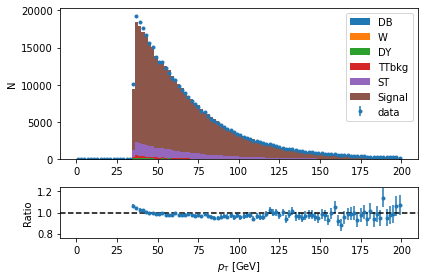

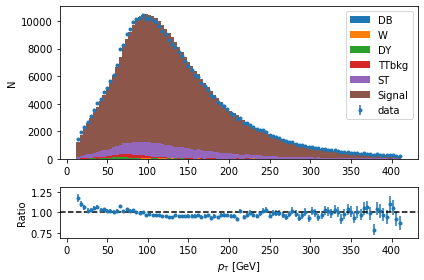

/tmp/ipykernel_21803/3404996798.py:21: RuntimeWarning: invalid value encountered in divide
  ratio = n_data[0]/summed_mc
/tmp/ipykernel_21803/3404996798.py:23: RuntimeWarning: invalid value encountered in divide
  ratio_err = np.sqrt((data_err/summed_mc)**2+(n_data[0]*mc_err/(summed_mc**2))**2)


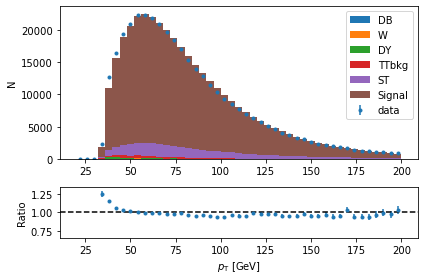

In [21]:
for hist in df:
    n_mc = df[hist]['MC']
    n_data = df[hist]['Data']['Data']
    stacked_histo(n_data, n_mc, savepath=f"./{hist}.pdf")